# About 

This notebook is intended to be a POC for the Skantze2017 LSTM RNN. 

## Setup 

In [1]:
 # Download libraries for environment. 

import sys 
import os 

# Env. vars to check if the notebook is running on colab, kaggle etc. 
IS_COLAB = "google.colab" in sys.modules 
IS_KAGGLE = "kaggle_secrets" in sys.modules 
IS_LOCAL = not (IS_COLAB or IS_KAGGLE)

if IS_COLAB:
    # Install the packages 
    %pip install -q -U tensorflow-addons
    %pip install -q -U transformers
    %pip install -q -U datasets
    print("You can safely ignore the package incompatibility errors.")
    # Mount the drive 
    from google.colab import drive 
    drive.mount("/drive")

In [33]:

import os
import pandas as pd
import numpy as np
from copy import deepcopy 

import random 
import shutil 
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"


# Pytorch imports 
import torch
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader

# Others 
import glob 

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)




In [3]:
# --  Set environment global vars. 

# Shared env. vars. 
GLOBAL_SEED = 42 
IS_CUDA_ENV = torch.cuda.is_available()
GLOBAL_DEVICE = torch.device('cuda') if IS_CUDA_ENV else torch.device('cpu')
SET_SEED = True # If true, sets the global seeds for this notebook. 
LIMITED_RESOURCES = not IS_CUDA_ENV

if LIMITED_RESOURCES:
    SMALL_DATASET_SIZE = 10

if IS_COLAB:
    LIMITED_RESOURCES = False 
   

In [4]:
# Configuring env. 
if SET_SEED:
    # to make this notebook's output stable across runs
    np.random.seed(GLOBAL_SEED) 
    torch.manual_seed(GLOBAL_SEED)

In [30]:
# Project Paths
NOTEBOOK_NAME = "skantze2017_model_poc"
PROJECT_ROOT_DIR = "/Users/muhammadumair/Documents/Repositories/mumair01-repos/TRP-Modeling/skantze_2017_continuous" 
# --- Input data dirs. 

FULL_DATALOADER_DIR = os.path.join(PROJECT_ROOT_DIR, "data","processed", "skantze2017_maptask_dataset_poc","full")
PROSODY_DATALOADER_DIR = os.path.join(PROJECT_ROOT_DIR, "data","processed", "skantze2017_maptask_dataset_poc","prosody")

# --- Result dirs. 
# NOTE: The model dir will have to change depending on where the models are stored. 
REPORTS_DIR = os.path.join(PROJECT_ROOT_DIR,"reports",NOTEBOOK_NAME)
SAVE_MODELS_DIR =  os.path.join(PROJECT_ROOT_DIR,"models",NOTEBOOK_NAME)

os.makedirs(REPORTS_DIR,exist_ok=True)
os.makedirs(SAVE_MODELS_DIR,exist_ok=True)


## Datasets and DataLoader 


### MapTask Dataclass and Method Definitions 

These are required to be in the same notebook to be loaded. 


NOTE: **DO NOT** modify these here, refer to 2.0-MU-Skantze-MapTask-Dataset-POC

In [6]:
def extract_voice_activity_labels(feature_df, N):
    # TODO: FIx the delimiter 
    feature_df = feature_df[["frameTime","voiceActivity"]]
    assert not feature_df.isnull().values.any()
    frame_times_ms = np.asarray(feature_df["frameTime"])
    voice_activity_annotations = np.asarray(feature_df["voiceActivity"])
    assert frame_times_ms.shape[0] == voice_activity_annotations.shape[0]
    labels = np.zeros((frame_times_ms.shape[0],N)) # target label shape: Num Frames x N
    for i in range(len(frame_times_ms)):
        # Pad the last labels with 0 if the conversation has ended 
        if i + N > len(frame_times_ms):
            concat = np.concatenate(
                [voice_activity_annotations[i:],
                 np.zeros(N - (len(frame_times_ms)-i))])
            labels[i] = concat
        else:
            labels[i] = voice_activity_annotations[i:i+N]
    labels_df = pd.DataFrame(labels) 
    labels_df.insert(0,"frameTime",frame_times_ms)
    assert not labels_df.isnull().values.any()
    return labels_df 


In [7]:

class Skantze2017VAPredictionMapTaskDataset(Dataset):
    """
    Maptask dataset for voice activity annotation sequence prediction.  
    NOTE: Needs a large amount of memory to load this. 
    """

    def __init__(self, feature_paths_map, sequence_length_ms, 
            prediction_length_ms, target_participant, frame_step_size_ms):
        # Vars. 
        self.feature_paths_map = feature_paths_map 
        self.sequence_length_ms = sequence_length_ms 
        self.prediction_length_ms = prediction_length_ms 
        self.target_participant = target_participant 
        self.frame_step_size_ms = frame_step_size_ms 
        # Calculated 
        self.num_context_frames = int(sequence_length_ms / frame_step_size_ms)
        self.num_target_frames = int(prediction_length_ms / frame_step_size_ms)
        # Storage 
        self.xs = [] 
        self.ys = [] 
        for dialogue in list(self.feature_paths_map.keys()):
            self.__load_data(dialogue)
        assert len(self.xs) == len(self.ys)

    def __len__(self):
        return len(self.xs)
    
    def __getitem__(self, idx):
        if idx > self.__len__():
            raise Exception 
        return self.xs[idx], self.ys[idx]

    def __load_data(self, dialogue):
        s0_feature_df, s1_feature_df = self.__load_dataframes(dialogue)
        # Extract the voice activity labels for s0 as the target labels
        s0_target_labels_df = extract_voice_activity_labels(
            s0_feature_df,self.num_target_frames)
        # Make sure none of the dfs have any nan values 
        assert not s0_feature_df.isnull().values.any() and \
            not s1_feature_df.isnull().values.any() and \
            not s0_target_labels_df.isnull().values.any()
        # Trim the dataframes to the same length 
        min_num_frames = np.min([len(s0_feature_df.index),len(s1_feature_df.index)])
        s0_feature_df = s0_feature_df[:min_num_frames]
        s1_feature_df = s1_feature_df[:min_num_frames]
        s0_target_labels_df = s0_target_labels_df[:min_num_frames]
        # Make sure they all have common frametimes
        assert s0_feature_df['frameTime'].equals(s1_feature_df['frameTime'])
        assert s0_feature_df['frameTime'].equals(s0_target_labels_df['frameTime'])
        s0_s1_df = pd.concat([s0_feature_df,s1_feature_df],axis=1)     
        assert not s0_s1_df.isnull().values.any()     
        # Determine the number of sequences for this dialogue 
        num_sequences = int(np.floor(len(s0_feature_df.index))/self.num_context_frames)
        for i in range(num_sequences):
            x = np.asarray(s0_s1_df.loc[:,s0_s1_df.columns != 'frameTime'][i * \
                self.num_context_frames : (i * self.num_context_frames) \
                    + self.num_context_frames])
            y = np.asarray(s0_target_labels_df.loc[:,s0_target_labels_df.columns\
                    != 'frameTime'][i * self.num_context_frames : \
                        (i * self.num_context_frames) + self.num_context_frames])[-1,:]
            self.xs.append(x)
            self.ys.append(y)

    def __load_dataframes(self, dialogue):
        if self.target_participant == "f":
            s0_feature_df = pd.read_csv(self.feature_paths_map[dialogue]["f"], index_col=0,delimiter=",") 
            s1_feature_df = pd.read_csv(self.feature_paths_map[dialogue]["g"],index_col=0,delimiter=",")
        else:
            s0_feature_df = pd.read_csv(self.feature_paths_map[dialogue]["g"],index_col=0,delimiter=",") 
            s1_feature_df = pd.read_csv(self.feature_paths_map[dialogue]["f"],index_col=0,delimiter=",")
        return s0_feature_df, s1_feature_df 



In [8]:
import random 

In [9]:
# NOTE:Seed worker can be used to ensure reproducibility in DataLoader 
# across runs. 
def seed_worker(worker_id):
    worker_seed =GLOBAL_SEED
    np.random.seed(worker_seed)
    random.seed(worker_seed)

def generate_dataloader(dataset, batch_size=32, shuffle=True, num_workers=0, 
        drop_last=True, pin_memory=True):
    return DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=shuffle, 
        num_workers=num_workers, 
        drop_last=drop_last, # We always want to remove the last incomplete batch. 
        pin_memory=pin_memory, 
        worker_init_fn=seed_worker)

### MapTask Loading Saved Datasets 

In [ ]:
from copy import deepcopy 

In [22]:
def load_saved_dataloader_util(feature_set):
    """
    Loads the dataloader saved by the 2.0 notebook. 
    """
    load_dir = FULL_DATALOADER_DIR if feature_set == "full" else PROSODY_DATALOADER_DIR
    dataloaders = [] 
    for dataset_name in ('train','val','test'):
        path = "{}/{}_dataloader_{}.pt".format(load_dir, dataset_name, feature_set)
        dataloader = torch.load(path)
        dataloaders.append(deepcopy(dataloader))
    return dataloaders

## Skantze 2017 Model

In [11]:
class Skantze2017LSTMPredictor(nn.Module):
    # TODO: The seed parameter is used to make sure that the layer initializations 
    # are the same across runs for model comparison - this should probably be 
    # either refactored or replaced.  
    def __init__(self, input_dim, hidden_dim, output_dim, layer_dim=1, seed=None):
        super().__init__()
        # Defining the vars. 
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim 
        self.output_dim = output_dim
        self.layer_dim = layer_dim
        # LSTM Layers
        if seed != None:
            torch.manual_seed(seed)
        self.lstm = nn.LSTM(input_dim, hidden_dim,layer_dim,batch_first=True) #  tanh activation is the default. 
        # Fully connected layer
        if seed != None:
            torch.manual_seed(seed)
        self.fc = nn.Linear(hidden_dim,output_dim,bias=True)
        if seed != None:
            torch.manual_seed(seed)
        self.fc_activation = nn.Sigmoid()

    def forward(self, x):
        # Initialize the hidden states for first input with zeroes. 
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        # Initialize the cell state for the first input with zeroes. 
        c0 = torch.zeros(self.layer_dim, x.size(0),self.hidden_dim).requires_grad_()

        # TODO: Still need to implement TBPTT in the model for the last 10 seconds, 
        # which is what was done in the Skantze paper. 

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        # Forward propagation by passing in the input, hidden state, and cell state into the model
        out, (hn, cn) = self.lstm(x.float(),(h0.detach(), c0.detach()))

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :] # Because we need the final output. 
        return self.fc_activation(self.fc(out))


In [12]:
model = Skantze2017LSTMPredictor(
    input_dim=130, 
    hidden_dim=40, 
    output_dim=60)

## Training

### Training Utility Methods 

In [13]:
# Writing training loop for a single batch 

def train_step(model,optimizer, loss_fn, x, y):
    # Make sure X type is correct. 
    x = x.type(torch.FloatTensor)
    # NOTE: The input should not have any nans. 
    assert not torch.isnan(x).any()
    model.train()
    optimizer.zero_grad()
    y_hat = model(x)
    assert not torch.isnan(y_hat).any()
    assert not torch.isnan(y).any()
    loss = loss_fn(y,y_hat)
    assert not torch.isnan(y).any()
    loss.backward()
    # nn.utils.clip_grad_norm_(model.parameters(),1.0)
    optimizer.step()
    return loss

In [14]:
def validate_step(model, loss_fn, x,y):
    with torch.no_grad():
        model.eval()
        y_hat = model(x)
        loss = loss_fn(y,y_hat).item()
        return loss 


In [15]:
def next_batch(dataloader):
    # Loop over dataset 
    for x_batch ,y_batch in dataloader:
        yield x_batch, y_batch 
    

In [16]:
def train(model,optimizer, loss_fn,train_dataloader, val_dataloader, n_epochs,
        validate_n_epochs=1,save_n_epochs=None, save_fn = None,
        print_n_epochs=None):
    # Set the model to training 
    model.train()

    # Vars. to record results across training 
    training_losses = []
    validation_losses = [] 
    
    for epoch in range(1, n_epochs+1):
        train_loss = 0.0 
        samples = 0.0 

        # Run the training batch 
        for batch_x, batch_y in next_batch(train_dataloader):
            loss = train_step(model, optimizer,loss_fn,batch_x, batch_y)
            # -- Updates loss etc. 
            train_loss += loss.item() * batch_y.size(0) 
            # TODO: Not sure if this is the correct way to get accuracy. 
            samples += batch_y.size(0)
        training_losses.append(train_loss / samples)

        # Run the validation batch
        if epoch % validate_n_epochs == 0:
            batch_val_losses = []
            for batch_x, batch_y in next_batch(val_dataloader):
                loss = validate_step(model, loss_fn,batch_x,batch_y)
                batch_val_losses.append(loss) 
            validation_losses.append(np.mean(batch_val_losses))
        else:
            batch_val_losses = 0.0
        
        # Save the model if required. 
        if (save_n_epochs != None and epoch % save_n_epochs == 0 and save_fn != None) or \
                (save_fn != None and epoch == n_epochs):
            info = {
                "epoch" : epoch, 
                "loss" : train_loss/samples,
                "val_loss" : np.mean(batch_val_losses)}
            save_fn(model ,info)
        # Print if needed 
        if print_n_epochs != None and epoch % print_n_epochs == 0:
            print(f"[{epoch}/{n_epochs}] Training loss: {train_loss/samples:.4f}\t \
                Validation loss: {np.mean(batch_val_losses):.4f}")

    return training_losses, validation_losses


### Skantze2017 Model Training 

In [17]:
FEATURE_SET = "full"


In [58]:
train_dataloader, val_dataloader, test_dataloader = load_saved_dataloader_util(FEATURE_SET)

In [19]:
INPUT_DIM = next(iter(train_dataloader))[0].shape[-1]
HIDDEN_DIM = 40 
PREDICTION_LENGTH_MS = 3000 
FRAME_STEP_SIZE_MS = 50 # acThe data is in time steps of 50 ms 
OUTPUT_DIM = int(PREDICTION_LENGTH_MS/FRAME_STEP_SIZE_MS) 

In [41]:
# Methods to save and load this specific model. 

import h5py 

def save_for_inference(save_path):
    assert not os.path.isfile(save_path)
    return lambda model, info: (
        torch.save({
            "kwargs" : {
                "input_dim" : model.input_dim, 
                "hidden_dim" : model.hidden_dim,
                "output_dim" : model.output_dim,
                "layer_dim" : model.layer_dim}, 
            "info" : deepcopy(info),
            "model_state_dict" : model.state_dict()}, save_path))
    
def load_for_inference(save_file_path):
    assert os.path.isfile(save_file_path) 
    checkpoint = torch.load(save_file_path)
    model = Skantze2017LSTMPredictor(**checkpoint["kwargs"])
    model.load_state_dict(checkpoint['model_state_dict'])
    return model, checkpoint['info']


def save_losses(save_dir, filename):
    assert os.path.isdir(save_dir)
    path = "{}/{}.h5".format(save_dir,filename)
    hf : h5py.File = h5py.File(path,'w')

    def h5_save_losses(grp_name, losses_dict):
        grp = hf.create_group(grp_name)
        for loss_name, losses in losses_dict.items():
            # loss_name = np.asarray(losses) 
            grp.create_dataset(loss_name, data=losses)
        
    return hf, path, h5_save_losses



In [31]:

# Define the save fn. 
path = "{}/sample_training.pt".format(SAVE_MODELS_DIR)
save_fn = save_for_inference(path)

In [34]:
# --- Testing the model 

model = Skantze2017LSTMPredictor(
    input_dim=INPUT_DIM,
    hidden_dim=HIDDEN_DIM, 
    output_dim=OUTPUT_DIM)

# Must define the loss function - Mean Absolute Error in original paper 
loss_fn = nn.L1Loss()
# RMSProp used in original paper 
optimizer = torch.optim.RMSprop(model.parameters(),lr=0.01,weight_decay=0.001)


training_losses, val_losses = train(
    model,optimizer, loss_fn,train_dataloader, val_dataloader, 
    n_epochs=5, print_n_epochs=1,save_fn=save_fn)


[1/5] Training loss: 0.2636	                 Validation loss: 0.2350
[2/5] Training loss: 0.2285	                 Validation loss: 0.2356
[3/5] Training loss: 0.2277	                 Validation loss: 0.2481
[4/5] Training loss: 0.2255	                 Validation loss: 0.2325
[5/5] Training loss: 0.2280	                 Validation loss: 0.2329


In [49]:
# Saving and loading the losses. 
hf, save_path, save_loss_fn= save_losses(REPORTS_DIR, "sample_saved_losses")
save_loss_fn(
    "sample_saved_losses", {
        "training" : training_losses, 
        "validation" : val_losses
    }
)
hf.close()
with h5py.File(save_path,'r') as f:
    training_losses = np.asarray(f['sample_saved_losses']['training'])
    val_losses =  np.asarray(f['sample_saved_losses']['validation'])


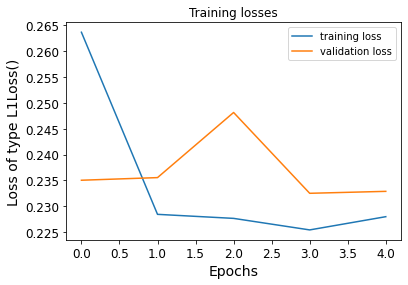

In [50]:
# Plot the losses 
plt.figure()
plt.plot(training_losses, label="training loss")
plt.plot(val_losses,label="validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss of type {}".format(loss_fn))
plt.title("Training losses")
plt.legend()
plt.show()


## Testing

In [55]:
def evaluate_skantze2017(model, test_dataloader):
    loss_fn = nn.L1Loss()
    losses = [] 
    va_losses = []
    with torch.no_grad():
        model.eval() 
        for x_batch, y_batch in next_batch(test_dataloader):
            x_batch = x_batch.view([1, -1, x_batch.size(-1)])
            y_hat = model(x_batch)
            loss = loss_fn(y_hat, y_batch)
            losses.append(loss) 
            nonzero_target_indices = np.nonzero(y_batch ==1)[:,1]
            if len(nonzero_target_indices) > 0:
                va_loss = loss_fn(
                    y_hat[:,nonzero_target_indices], y_batch[:,nonzero_target_indices])
                va_losses.append(va_loss)
        return losses , va_losses
            

In [56]:
# Loading the model 
path = "{}/sample_training.pt".format(SAVE_MODELS_DIR)
model, info = load_for_inference(path)
model.eval()

Skantze2017LSTMPredictor(
  (lstm): LSTM(130, 40, batch_first=True)
  (fc): Linear(in_features=40, out_features=60, bias=True)
  (fc_activation): Sigmoid()
)

In [59]:
l1_losses, va_losses = evaluate_skantze2017(model, test_dataloader) 
# TODO: This is an issue because it means that 1 labels are predominantly not 
# being predicted correctly i.e., the model is almost always saying that 
# the speaker VA probability is low. 
np.mean(l1_losses), np.mean(va_losses)

(0.21257003, 0.9904395)